In [1]:
import os

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

from tensorflow.keras import layers
from tensorflow.keras import losses

In [2]:
train_dir = "train"
test_dir = "test"
os.listdir(train_dir)

['баланс', 'операции']

In [3]:
batch_size = 32
seed = 32

raw_train_dataset = tf.keras.utils.text_dataset_from_directory(
    train_dir,
    labels="inferred",
    batch_size=batch_size,
    validation_split=0.2,
    subset="training",
    seed=seed
)

raw_train_dataset

Found 225 files belonging to 2 classes.
Using 180 files for training.


<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [4]:
raw_validation_dataset = tf.keras.utils.text_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset="validation",
    seed=seed,
)

raw_validation_dataset

Found 225 files belonging to 2 classes.
Using 45 files for validation.


<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [5]:
raw_test_dataset = tf.keras.utils.text_dataset_from_directory(
    test_dir,
    batch_size=batch_size,
)

raw_test_dataset

Found 191 files belonging to 2 classes.


<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [6]:
max_features = 10000
sequence_length = 15

vectorization_layer = layers.TextVectorization(
    max_tokens=max_features,
    output_mode="int",
    output_sequence_length=sequence_length,
)

vectorization_layer

<TextVectorization name=text_vectorization, built=False>

In [7]:
train_text = raw_train_dataset.map(lambda batch, label: batch)
vectorization_layer.adapt(train_text)

2024-05-27 21:36:41.272411: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [8]:
print('Vocabulary size: {}'.format(len(vectorization_layer.get_vocabulary())))

Vocabulary size: 204


In [9]:
def vector_text(text, label):
    text = tf.expand_dims(text, -1)
    print(text)
    return vectorization_layer(text), label

In [10]:
vector_text("баланс месяц", "баланс")

tf.Tensor([b'\xd0\xb1\xd0\xb0\xd0\xbb\xd0\xb0\xd0\xbd\xd1\x81 \xd0\xbc\xd0\xb5\xd1\x81\xd1\x8f\xd1\x86'], shape=(1,), dtype=string)


(<tf.Tensor: shape=(1, 15), dtype=int64, numpy=array([[11, 18,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]])>,
 'баланс')

In [11]:
train_dataset = raw_train_dataset.map(vector_text)
validation_dataset = raw_validation_dataset.map(vector_text)
test_dataset = raw_test_dataset.map(vector_text)

Tensor("ExpandDims:0", shape=(None, 1), dtype=string)
Tensor("ExpandDims:0", shape=(None, 1), dtype=string)
Tensor("ExpandDims:0", shape=(None, 1), dtype=string)


In [12]:
embedding_dim = 16

model = tf.keras.Sequential([
    layers.Embedding(max_features, embedding_dim),
    layers.Dropout(0.2),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.2),
    layers.Dense(2, activation="sigmoid")
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [13]:
model.compile(
    optimizer="adam",
    loss=losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"],
)

In [14]:
epochs = 10

history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs
)

Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5308 - loss: 0.6901 - val_accuracy: 0.5333 - val_loss: 0.6806
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5800 - loss: 0.6739 - val_accuracy: 0.5333 - val_loss: 0.6690
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5961 - loss: 0.6575 - val_accuracy: 0.5333 - val_loss: 0.6583
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6102 - loss: 0.6485 - val_accuracy: 0.5333 - val_loss: 0.6479
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5544 - loss: 0.6429 - val_accuracy: 0.5333 - val_loss: 0.6374
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6160 - loss: 0.6224 - val_accuracy: 0.5333 - val_loss: 0.6271
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5869 - loss: 0.6207 - val_accuracy: 0.5556 - val_loss: 0.6166
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6169 - loss: 0.6021 - val_accuracy: 0.5556 - val_loss: 0.6060
Epoch 9

In [15]:
loss, accuracy = model.evaluate(test_dataset)

print("Loss:", loss)
print("Accuracy:", accuracy)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step - accuracy: 0.8071 - loss: 0.5124
Loss: 0.5252190828323364
Accuracy: 0.7801046967506409


In [16]:
history_dict = history.history
history_dict.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

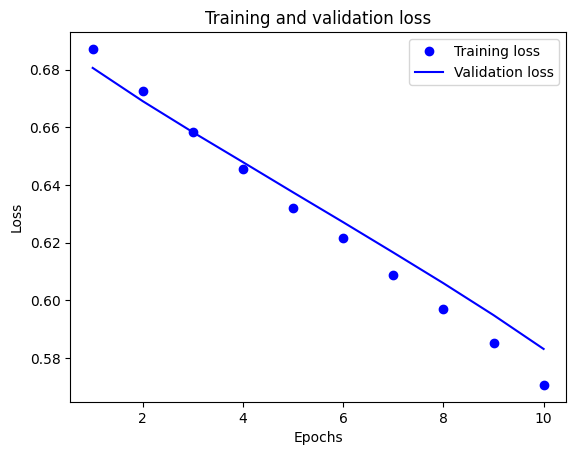

In [17]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

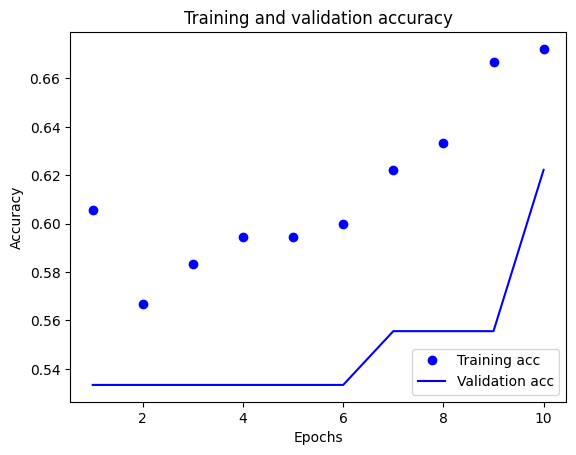

In [18]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [19]:
export_model = tf.keras.Sequential([
    vectorization_layer,
    model,
    layers.Activation('sigmoid')
])

export_model.compile(
    optimizer="adam",
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

acc = export_model.evaluate(raw_test_dataset)
acc

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 749us/step - accuracy: 0.7832 - loss: 0.0000e+00


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:602: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


[0.0, 0.0, 0.7801046967506409, 0.7801046967506409]

In [25]:
examples = tf.constant([
    "какой баланс у меня",
    "Покажите мне историю переводов за последний месяц",
    "операции",
    "Покажите историю всех моих транзакций",
    "Покажите историю всех моих переводов за последние два года",
    "Покажите историю всех моих переводов за последние два года",
    "покажи историю платежей.",
])

predictions = export_model.predict(examples)
for i in predictions:
    print(i)
    max_value = np.argmax(i)
    print(raw_train_dataset.class_names[max_value])
    print("-------------------------")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
[0.63799334 0.6045524 ]
баланс
-------------------------
[0.62623537 0.6184944 ]
баланс
-------------------------
[0.6420499  0.60083485]
баланс
-------------------------
[0.6317877 0.6119533]
баланс
-------------------------
[0.6225144 0.6227606]
операции
-------------------------
[0.6225144 0.6227606]
операции
-------------------------
[0.63783133 0.60582715]
баланс
-------------------------


In [24]:
export_model.save("model.keras", overwrite=True)